In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [2]:
samples_dir = "/eos/home-d/dmapelli/public/latino/Full2017v6"
cut = "lowen_looseVBS"
version = "v3"

In [3]:
model_dir = f"{samples_dir}/{cut}/models/{version}"
import os 
os.makedirs(model_dir, exist_ok=True)

In [40]:
signal = pickle.load(open(f"{samples_dir}/{cut}/samples/for_training/signal_balanced.pkl", "rb"))
bkg = pickle.load(open(f"{samples_dir}/{cut}/samples/for_training/background_balanced.pkl", "rb"))

## Samples preparation for NN

In [70]:
## using 
## source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh
#!pip3 install --user imbalanced-learn==0.5

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import backend as K
from keras.callbacks import *

Using TensorFlow backend.


'mjj_vbs', 'vbs_0_pt', 'vbs_1_pt', 'vbs_0_eta', 'vbs_1_eta', 'deltaeta_vbs', 'deltaphi_vbs', 
'mjj_vjet', 'vjet_0_pt', 'vjet_1_pt', 'vjet_0_eta', 'vjet_1_eta', 'Lepton_pt', 'Lepton_eta', 
'Lepton_flavour', 'PuppiMET', 'nJets', 'N_jets_central', 'N_jets_forward', 'Zvjets_0', 
'Zlep', 'Asym_vbs', 'Asym_vjet', 'A_ww', 'Mw_lep_reco', 'Mtw_lep', 'w_lep_pt', 'Mww', 'R_ww', 'R_mw', 'Centr_vbs', 'Centr_ww

In [6]:
import yaml
yaml_vars = yaml.safe_load(open(f"{samples_dir}/{cut}/models/{version}/variables.yml"))
print(type(yaml_vars), yaml_vars)
cols = yaml_vars

<class 'list'> ['mjj_vbs', 'vbs_0_pt', 'vbs_1_pt', 'vbs_0_eta', 'vbs_1_eta', 'deltaeta_vbs', 'deltaphi_vbs', 'mjj_vjet', 'vjet_0_pt', 'vjet_1_pt', 'vjet_0_eta', 'vjet_1_eta', 'Lepton_pt', 'Lepton_eta', 'Lepton_flavour', 'PuppiMET', 'nJets', 'N_jets_central', 'N_jets_forward', 'Zvjets_0', 'Zlep', 'Asym_vbs', 'Asym_vjet', 'A_ww', 'Mw_lep_reco', 'Mtw_lep', 'w_lep_pt', 'Mww', 'R_ww', 'R_mw', 'Centr_vbs', 'Centr_ww']


In [52]:
X_sig = signal[cols].values
X_bkg = bkg[cols].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight"]*signal["XSWeight_norm"]).values
W_bkg = (bkg["weight"]*bkg["XSWeight_norm"]).values

In [53]:
X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])

In [54]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

vjet_0_eta


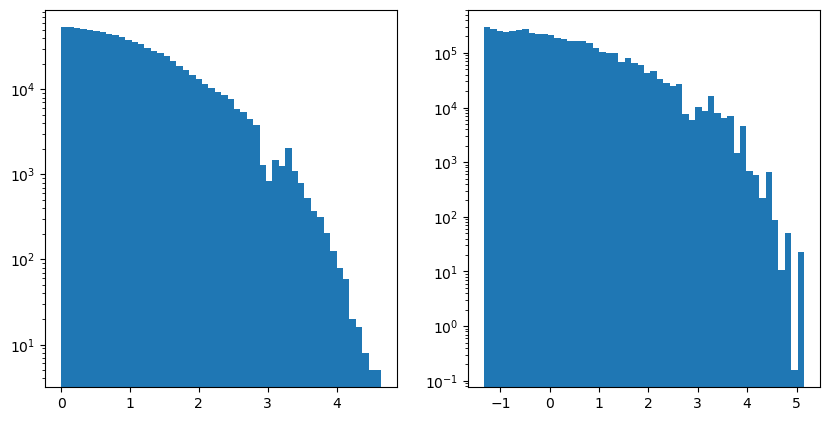

In [11]:
i = 10
print(cols[i])
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi=100)
ax1.hist(X[:,i], bins=50)
ax1.set_yscale("log")
ax2.hist(X_scaled[:,i], weights=W, bins=50)
plt.yscale("log")

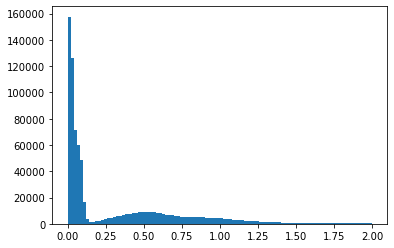

In [11]:
_ = plt.hist(W, bins=100, range=(0,2))

##  Balancing
Let's give 25% to validation (validation during training + test). 
The validation is then split in 50%-50% for training validation and final result

In [55]:
X_train, X_temp, y_train, y_temp, W_train, W_temp = train_test_split(X_scaled, Y,      W,      test_size=0.2)
X_val,   X_test, y_val,   y_test, W_val,   W_test = train_test_split(X_temp,   y_temp, W_temp, test_size=0.5)

In [56]:
print("Training dataset: ", X_train.shape)

Training dataset:  (692845, 32)


Create generators to balance signal and background

In [57]:
training_generator,   steps_per_epoch_train = balanced_batch_generator(X_train, y_train, W_train, batch_size=1024, sampler=RandomOverSampler())
validation_generator, steps_per_epoch_val   = balanced_batch_generator(X_val,   y_val,   W_val,   batch_size=1024, sampler=RandomOverSampler())

## Keras model

In [51]:
model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], activation="relu"))
model.add(Dropout(0.4))
#model.add(Dense(50, activation="relu"))
#model.add(Dropout(0.3))
model.add(Dense(80, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               3300      
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 80)                8080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                4050      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total para

In [ ]:
auto_save = ModelCheckpoint("../models/model12_balanced_100_50.hd5", monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=5)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                            patience=10, verbose=1)

In [18]:
history = model.fit(
            X_train,y_train, 
            sample_weight=W_train, 
            epochs=50,
            validation_data = (X_val, y_val, W_val),
            batch_size=1024,
            shuffle=True 
            )

Train on 649542 samples, validate on 162386 samples
Epoch 1/50
649542/649542 [==============================] - 4s 5us/step - loss: 2.6958e-04 - acc: 0.8436 - val_loss: 1.0066e-04 - val_acc: 0.8571
Epoch 2/50
649542/649542 [==============================] - 3s 5us/step - loss: 1.0855e-04 - acc: 0.8575 - val_loss: 9.5359e-05 - val_acc: 0.8571
Epoch 3/50
649542/649542 [==============================] - 3s 5us/step - loss: 1.0484e-04 - acc: 0.8575 - val_loss: 9.4330e-05 - val_acc: 0.8571
Epoch 4/50
649542/649542 [==============================] - 3s 5us/step - loss: 1.0311e-04 - acc: 0.8575 - val_loss: 9.3976e-05 - val_acc: 0.8571
Epoch 5/50
649542/649542 [==============================] - 3s 5us/step - loss: 1.0224e-04 - acc: 0.8576 - val_loss: 9.2399e-05 - val_acc: 0.8571
Epoch 6/50
649542/649542 [==============================] - 3s 5us/step - loss: 1.0064e-04 - acc: 0.8576 - val_loss: 9.2163e-05 - val_acc: 0.8571
Epoch 7/50
649542/649542 [==============================] - 3s 5us/step 

In [72]:
history = model.fit_generator(
            training_generator, 
            epochs=500,
            initial_epoch=200,
            steps_per_epoch=steps_per_epoch_train, 
            validation_data = validation_generator, 
            validation_steps = steps_per_epoch_val,
            callbacks = [], 
            )

Epoch 201/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.4007 - acc: 0.5970 - val_loss: 0.4173 - val_acc: 0.6169
Epoch 202/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.4011 - acc: 0.5992 - val_loss: 0.4171 - val_acc: 0.6189
Epoch 203/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.4020 - acc: 0.6018 - val_loss: 0.4179 - val_acc: 0.6243
Epoch 204/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.4018 - acc: 0.5992 - val_loss: 0.4140 - val_acc: 0.6151
Epoch 205/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.4015 - acc: 0.6015 - val_loss: 0.4171 - val_acc: 0.6184
Epoch 206/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.4024 - acc: 0.6012 - val_loss: 0.4198 - val_acc: 0.6272
Epoch 207/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.4015 - acc: 0.6006 - val_loss: 0.4183 - val_acc: 0.6248
Epoch 208/500
1160/1160 [================

Epoch 261/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.4006 - acc: 0.5998 - val_loss: 0.4143 - val_acc: 0.6157
Epoch 262/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.4001 - acc: 0.6024 - val_loss: 0.4192 - val_acc: 0.6145
Epoch 263/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.4001 - acc: 0.6021 - val_loss: 0.4201 - val_acc: 0.6342
Epoch 264/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.4018 - acc: 0.6039 - val_loss: 0.4192 - val_acc: 0.6238
Epoch 265/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.3999 - acc: 0.6003 - val_loss: 0.4193 - val_acc: 0.6121
Epoch 266/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.3999 - acc: 0.5985 - val_loss: 0.4173 - val_acc: 0.6293
Epoch 267/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.4004 - acc: 0.5975 - val_loss: 0.4187 - val_acc: 0.6105
Epoch 268/500
1160/1160 [================

Epoch 321/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.3981 - acc: 0.5968 - val_loss: 0.4156 - val_acc: 0.6067
Epoch 322/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.4010 - acc: 0.5973 - val_loss: 0.4203 - val_acc: 0.6161
Epoch 323/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.3985 - acc: 0.6017 - val_loss: 0.4189 - val_acc: 0.6129
Epoch 324/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.4003 - acc: 0.6030 - val_loss: 0.4177 - val_acc: 0.6083
Epoch 325/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.3986 - acc: 0.6013 - val_loss: 0.4221 - val_acc: 0.6076
Epoch 326/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.4009 - acc: 0.6017 - val_loss: 0.4207 - val_acc: 0.6071
Epoch 327/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.4004 - acc: 0.6036 - val_loss: 0.4178 - val_acc: 0.6066
Epoch 328/500
1160/1160 [================

Epoch 381/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.4007 - acc: 0.6034 - val_loss: 0.4219 - val_acc: 0.6229
Epoch 382/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.3987 - acc: 0.6049 - val_loss: 0.4203 - val_acc: 0.6097
Epoch 383/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.3983 - acc: 0.6029 - val_loss: 0.4177 - val_acc: 0.6124
Epoch 384/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.4005 - acc: 0.6027 - val_loss: 0.4193 - val_acc: 0.6131
Epoch 385/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.3978 - acc: 0.6041 - val_loss: 0.4184 - val_acc: 0.6099
Epoch 386/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.3973 - acc: 0.6019 - val_loss: 0.4198 - val_acc: 0.6115
Epoch 387/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.3983 - acc: 0.6020 - val_loss: 0.4201 - val_acc: 0.6164
Epoch 388/500
1160/1160 [================

Epoch 441/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.3948 - acc: 0.6006 - val_loss: 0.4198 - val_acc: 0.6042
Epoch 442/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.3985 - acc: 0.6025 - val_loss: 0.4183 - val_acc: 0.6106
Epoch 443/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.3973 - acc: 0.6043 - val_loss: 0.4188 - val_acc: 0.6185
Epoch 444/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.3974 - acc: 0.6016 - val_loss: 0.4208 - val_acc: 0.5998
Epoch 445/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.3955 - acc: 0.6000 - val_loss: 0.4217 - val_acc: 0.6097
Epoch 446/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.3970 - acc: 0.6010 - val_loss: 0.4210 - val_acc: 0.6051
Epoch 447/500
1160/1160 [==============================] - 7s 6ms/step - loss: 0.3955 - acc: 0.6042 - val_loss: 0.4189 - val_acc: 0.6087
Epoch 448/500
1160/1160 [================

In [82]:
model.save(f"{model_dir}/model.h5")

>>> Computing AUC...


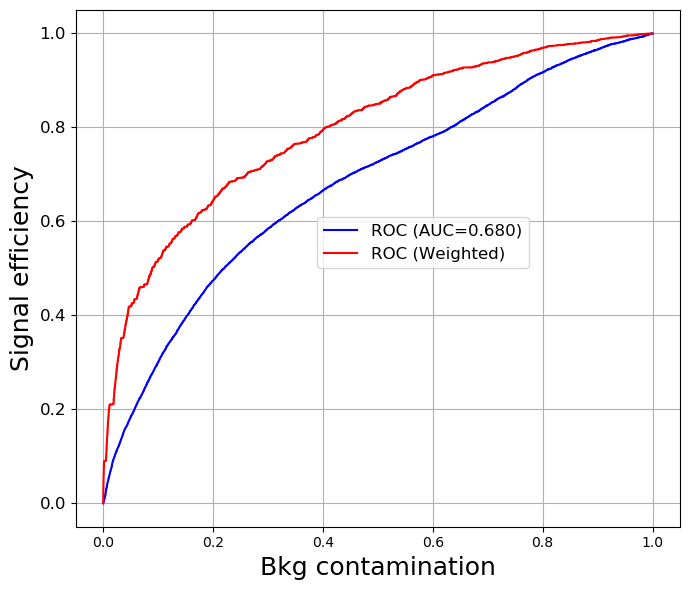

In [83]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred = model.predict(X_test)
auc = roc_auc_score(y_test,pred)
fpW, tpW, thW = roc_curve(y_test, pred, sample_weight=W_test)
fp, tp, th = roc_curve(y_test, pred)
#print("AUC score: " + str(auc))

fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

ax1.plot(fp, tp, label=f"ROC (AUC={auc:.3f})", color="blue")
ax1.plot(fpW, tpW, label=f"ROC (Weighted)", color="red")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18)

#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large")

ax1.grid()

ax1.legend(loc=(0.4, 0.5), fontsize="large")

fig.tight_layout()

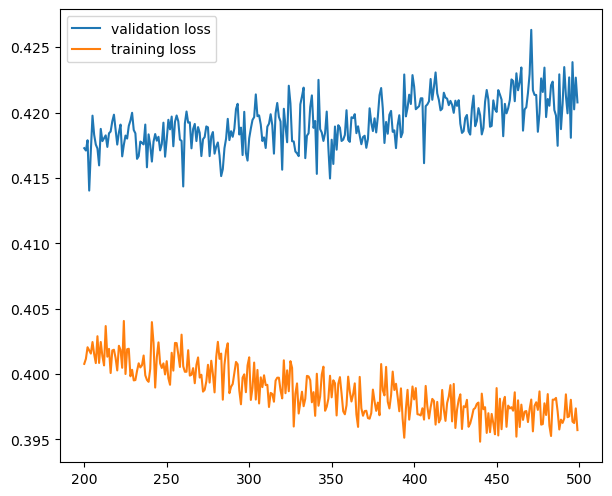

In [73]:
fig, ax = plt.subplots(figsize=(7,6), dpi=100)
ax.plot(history.epoch, history.history["val_loss"], label="validation loss")
ax.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

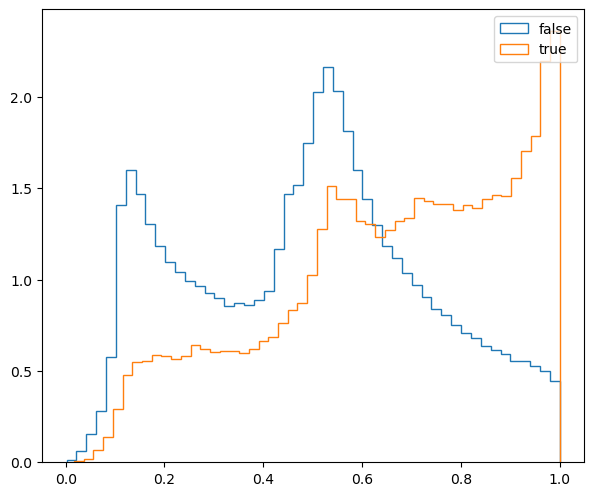

In [74]:
results = model.predict(X_train)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(results[y_train==0], bins=50,density=True, label="false", histtype="step")
plt.hist(results[y_train==1], bins=50, density=True, label="true", histtype="step")
#plt.yscale("log")
plt.legend()

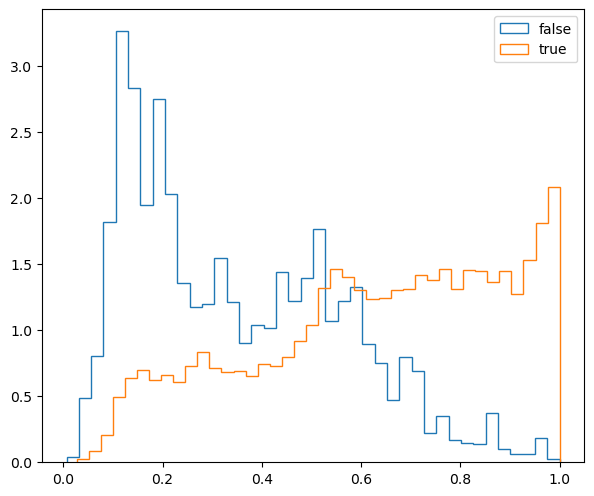

In [75]:
results = model.predict(X_test, batch_size=2048)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(results[y_test==0],weights=W_test[y_test==0], bins=40,density=True, label="false", histtype="step")
plt.hist(results[y_test==1],weights=W_test[y_test==1], bins=40, density=True, label="true", histtype="step")
#plt.yscale("log")
plt.legend()

## Evaluation by sample

In [76]:
bkg["y"] = model.predict(scaler.transform(bkg[cols].values), batch_size=2048)

In [77]:
signal["y"] = model.predict(scaler.transform(signal[cols].values), batch_size=2048)

In [78]:
wjets = bkg[bkg["sample_name"] == "Wjets"]
top = bkg[bkg["sample_name"] == "top"]
dy = bkg[bkg["sample_name"] == "DY"]

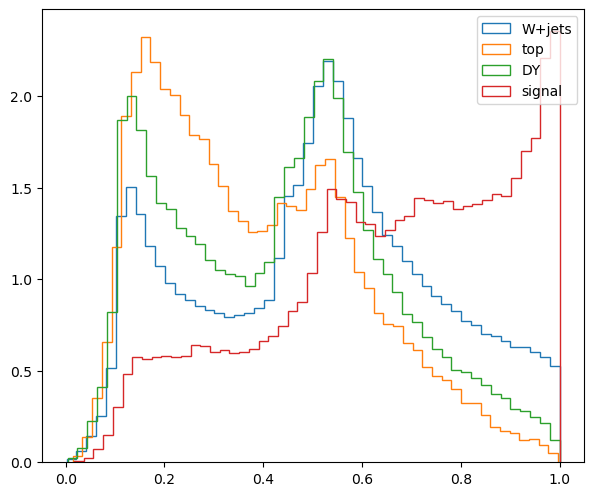

In [79]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(bkg[bkg["sample_name"] == "Wjets"]["y"], bins=50, density=True, label="W+jets", histtype="step")
plt.hist(bkg[bkg["sample_name"] == "top"]["y"],   bins=50, density=True, label="top",    histtype="step")
plt.hist(bkg[bkg["sample_name"] == "DY"]["y"],    bins=50, density=True, label="DY",     histtype="step")

plt.hist(signal["y"], bins=50,density=True, label="signal", histtype="step")
#plt.yscale("log")
plt.legend()

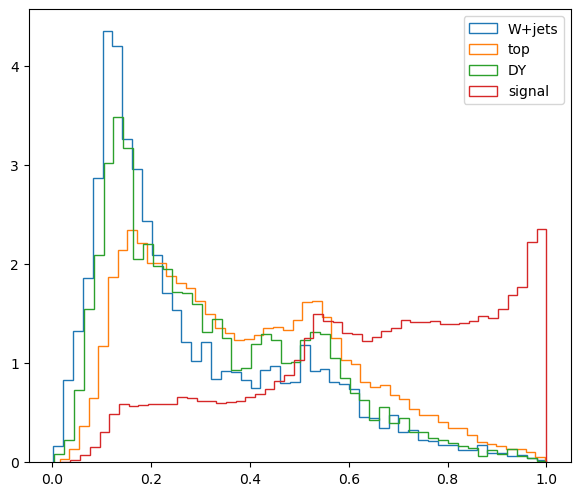

In [80]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(wjets["y"], weights=wjets.XSWeight_norm, bins=50, density=True, label="W+jets", histtype="step")
plt.hist(top["y"],   weights=top.XSWeight_norm,  bins=50, density=True, label="top",    histtype="step")
plt.hist(dy["y"],    weights=dy.XSWeight_norm,  bins=50, density=True, label="DY",     histtype="step")

plt.hist(signal["y"], weights=signal.XSWeight_norm, bins=50,density=True, label="signal", histtype="step")
#plt.yscale("log")
plt.legend()